In [5]:
import numpy as np
import pandas as pd
import os
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
import kaggle

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


<font color = 'blue'>
<font size = 3>
Loading the input data

In [6]:
path = '/kaggle/input/histopathologic-cancer-detection/train/'
train_files = os.listdir(path)

In [7]:
train_files[:5]

['d43c081bafa286f9c1f7e921883f26ceafebc912.tif',
 '092d0eedebce504847715ee046b6ad74b57599b4.tif',
 'b0d2582c6218a8764323fc940b41312282b99bf4.tif',
 '187c99df762f13f99818e5593d4bab4c6577e7e3.tif',
 '7c5270c83837de5a5cbb2dca511559dc39d19d53.tif']

<font color = 'blue'>
<font size = 3>
Loading only 20K images for training, as the time overhead would be significant with 200K points.

In [34]:
# loading images in X_train
def loadfiles(path, n):
    indices = np.random.randint(0, len(train_files), n)
    return list(map(lambda i: train_files[i], indices)), np.array(list(map(lambda i: cv2.imread(path + train_files[i]), tqdm(indices, position = 0, leave = 0))))

train_files_selcted, X_train = loadfiles(path, 20000)

## Exploratory data analysis

In [35]:
len(train_files_selcted)

20000

In [36]:
X_train.shape

(20000, 96, 96, 3)

<font color = 'blue'>
<font size = 3>
Plotting five random images from the training set.

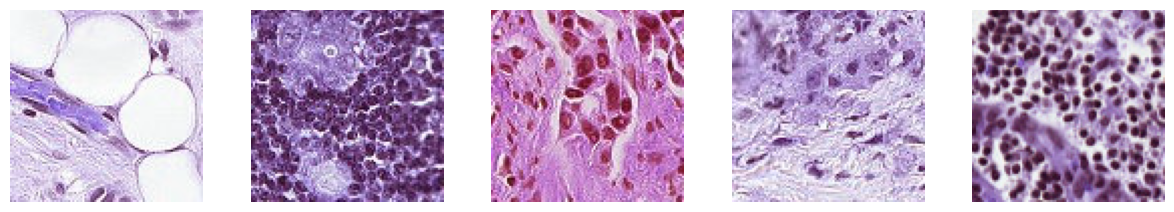

In [37]:
# ploting n random images from X_train
import random

def plot_images(X_train, n):
  """Plots n random images from X_train."""
  random_indices = random.sample(range(X_train.shape[0]), n)
  fig, axes = plt.subplots(1, n, figsize=(15, 2.5))
  def plot_image(image, ax):
      ax.imshow(image)
      ax.axis('off')
  dum = list(map(lambda i: plot_image(X_train[random_indices[i]], axes[i]), range(n)))
  plt.show()

plot_images(X_train, 5)

<font color = 'blue'>
<font size = 3>
Checking for NANs in X_train

In [38]:
print(f'Number of NANs in X_train: {np.isnan(X_train).sum()}')

Number of NANs in X_train: 0


<font color = 'blue'>
<font size = 3>
All The images have their values between 0 and 255, as shown below.

In [39]:
print('max values of the images:', np.max(X_train, axis = (0,1,2)))
print('min values of the images:', np.min(X_train, axis = (0,1,2)))

max values of the images: [255 255 255]
min values of the images: [0 0 0]


<font color = 'blue'>
<font size = 3>
Plotting the distribution of values in all the images stored in X_train.

(array([1.00277460e+07, 2.27285160e+07, 3.66214360e+07, 4.29191470e+07,
        5.15339290e+07, 5.62361220e+07, 6.48738800e+07, 6.55122490e+07,
        8.69325390e+07, 1.15574436e+08]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]),
 <BarContainer object of 10 artists>)

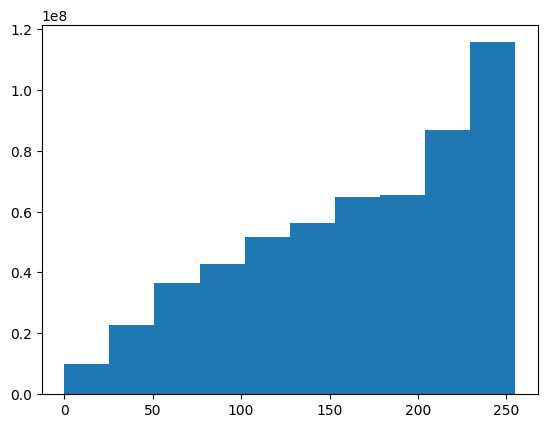

In [40]:
plt.hist(np.ravel(X_train))

#### Loading the labels:

<font color = 'blue'>
<font size = 3>
Storing all the labels in the labels data frame

In [41]:
labelpath = '/kaggle/input/histopathologic-cancer-detection/'
labels = pd.read_csv(labelpath + 'train_labels.csv')

In [42]:
labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


<font color = 'blue'>
<font size = 3>
Loading the labels of the images stored in X_train

In [43]:
y_train = np.array(list(map(lambda x: labels[labels['id'] == x[:-4]]['label'], tqdm(train_files_selcted, position= 0, leave= True))))

100%|██████████| 20000/20000 [05:07<00:00, 65.09it/s]


In [44]:
y_train = y_train.flatten()
y_train

array([1, 1, 0, ..., 1, 0, 0])

<font color = 'blue'>
<font size = 3>
Checking for NANs in y_train

In [45]:
nan_count = np.isnan(y_train).sum()
print(f"Number of NANs: {nan_count}")

Number of NANs: 0


<font color = 'blue'>
<font size = 3>
Chacking the proprtion of labels in various categories

<BarContainer object of 2 artists>

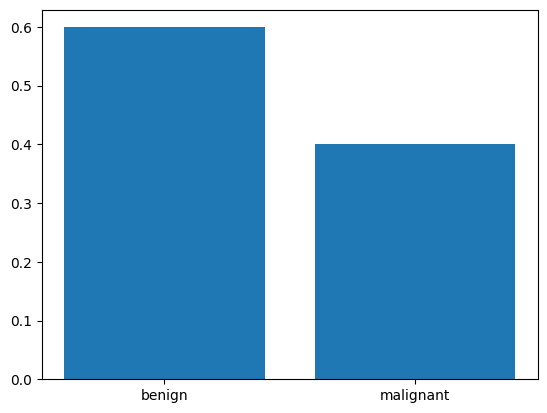

In [46]:
plt.bar(['benign','malignant'],np.unique(y_train,return_counts=True)[1]/len(y_train))

In [20]:
testpath = '/kaggle/input/histopathologic-cancer-detection/test/'
test_files= os.listdir(testpath)
X_test = np.array(list(map(lambda x: cv2.imread(testpath + x), tqdm(test_files, leave = True))))

100%|██████████| 57458/57458 [07:59<00:00, 119.72it/s]


In [21]:
test_files_id = list(map(lambda x: x[:-4], tqdm(test_files, position = 0, leave = True)))
# test_files_id

100%|██████████| 57458/57458 [00:00<00:00, 2309876.25it/s]


# Data Analysis

<font color = 'blue'>
<font size = 4>
Basic model with convolution layers, resacling after input convolution, and maxpooling to reduce the size of the convolution layers.

In [47]:
input_shape = (96, 96, 3) # appropriate with the input data
model = keras.Sequential([
    layers.Input(shape=input_shape),
    layers.Rescaling(1./255),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid') # For binary classification
])

model.compile(loss='binary_crossentropy',
              metrics=['accuracy'])
model.optimizer = Adam(learning_rate= 0.0001)

model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_4 (Rescaling)              │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 94, 94, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 47, 47, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 20, 20, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │       1,638,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,731,905 (6.61 MB)

 Trainable params: 1,731,905 (6.61 MB)

 Non-trainable params: 0 (0.00 B)

In [48]:
es1 = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
hist1 = model.fit(X_train, y_train, validation_split=0.2, epochs=50, callbacks=[es1])

Epoch 1/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.7029 - loss: 0.5659 - val_accuracy: 0.7860 - val_loss: 0.4631
Epoch 2/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.7857 - loss: 0.4679 - val_accuracy: 0.7853 - val_loss: 0.4630
Epoch 3/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.7937 - loss: 0.4516 - val_accuracy: 0.8005 - val_loss: 0.4368
Epoch 4/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.7997 - loss: 0.4409 - val_accuracy: 0.7987 - val_loss: 0.4319
Epoch 5/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8109 - loss: 0.4218 - val_accuracy: 0.8055 - val_loss: 0.4245
Epoch 6/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8160 - loss: 0.4174 - val_accuracy: 0.8105 - val_loss: 0.4087
Epoch 7/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8242 - loss: 0.4022 - val_accuracy: 0.8148 - val_loss: 0.4125
Epoch 8/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8351 - loss: 0.3906 - val_accu

In [49]:
def plot_history(hist):
  fig, ax = plt.subplots(1, 2, figsize=(12, 4))
  ax[0].plot(hist.epoch, hist.history['loss'], label='Training Loss')
  ax[0].plot(hist.epoch, hist.history['val_loss'], label='Validation Loss')
  ax[1].plot(hist.epoch, hist.history['accuracy'], label='Training Accuracy')
  ax[1].plot(hist.epoch, hist.history['val_accuracy'], label='Validation Accuracy')
  ax[0].legend()
  ax[1].legend()
  plt.show()
  return

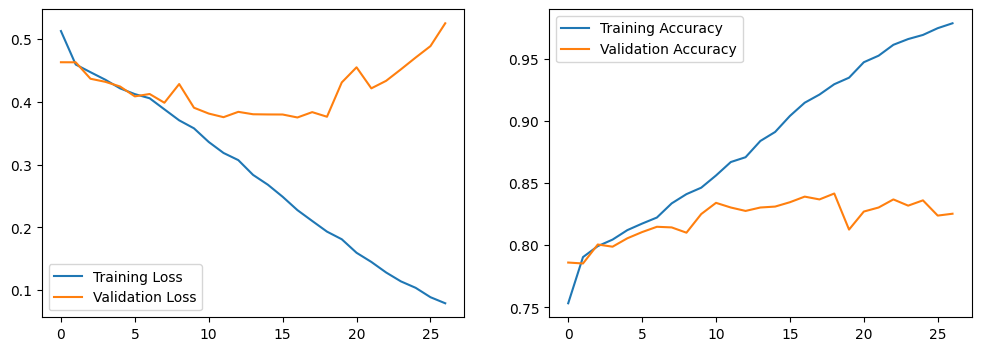

In [50]:
plot_history(hist1)

<font color = 'blue'>
<font size = 3>
Below, we predict the results on the test dataset.

In [51]:
res = model.predict(X_test)
res = res.flatten()

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


<font color = 'blue'>
    <font size = 3>
We create below helper functions to create and submit a csv file to Kaggle. In addition, we create another helper function to get the score on the test dataset from Kaggle. 

In [52]:
# predicting on the test dataset
def predictOnTeset(model):
    res = model.predict(X_test)
    return res.flatten()

# Creating and uploading a test result csv file to Kaggle
def createFileAndUploadToKaggle(filename, predictions):
    path = '/kaggle/working/'
    pd.DataFrame({'id': test_files_id, 'label':predictions}).to_csv(path + filename, index= False)
    kaggle.api.authenticate()
    subms = kaggle.api.competition_submit(path + filename,'ghhb','histopathologic-cancer-detection')
    return subms

# Obtaining score on the test dataset from Kaggle
def getKaggleScore(subms):
    kaggle.api.authenticate()
    sublist = kaggle.api.competitions_submissions_list('histopathologic-cancer-detection')
    # print(subms.ref)
    for sub in sublist:
        if(sub['ref'] == subms.ref): 
            print('The accuracy score is', sub['publicScore'])
            return sub['publicScore']

In [53]:
subms = createFileAndUploadToKaggle('model1Submission.csv', res)

100%|██████████| 2.85M/2.85M [00:00<00:00, 6.69MB/s]


In [54]:
score = getKaggleScore(subms)

The accuracy score is 0.8863


<font color = 'blue'>
<font size = 4>
The above plots show that validation loss reaches a minima and then starts to increase; similarly, the validation accuracy achieves a maximum and then starts decreasing, while training loss and accuracy show a monotonous decreasing and increasing trend, respectively, implying overfiting. As for the accuracy on the test set, it is 0.8863.

### Model with Strides and no Max-pooling.

In [57]:
input_shape = (96, 96, 3) # appropriate with the input data
model2 = keras.Sequential([
    layers.Input(shape=input_shape),
    layers.Rescaling(1./255),
    layers.Conv2D(32, (3, 3), activation='relu', strides= (2,2)),
    layers.Conv2D(64, (3, 3), activation='relu', strides= (2,2)),
    layers.Conv2D(128, (3, 3), activation='relu', strides= (2,2)),
    layers.Conv2D(256, (3, 3), activation='relu',strides= (2,2)),
    layers.Conv2D(512, (3, 3), activation='relu', strides= (2,2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(1, activation='sigmoid') # For binary classification
])

model2.compile(loss='binary_crossentropy',
              metrics=['accuracy'])
model2.optimizer = Adam(learning_rate= 0.00001)

model2.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_6 (Rescaling)              │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 47, 47, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 23, 23, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 11, 11, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 5, 5, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 2, 2, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,618,177 (9.99 MB)

 Trainable params: 2,618,177 (9.99 MB)

 Non-trainable params: 0 (0.00 B)

In [58]:
es1 = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
hist2 = model2.fit(X_train, y_train, validation_split=0.2, epochs=50, callbacks=[es1])

Epoch 1/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.6151 - loss: 0.6566 - val_accuracy: 0.7605 - val_loss: 0.5019
Epoch 2/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7692 - loss: 0.4987 - val_accuracy: 0.7742 - val_loss: 0.4878
Epoch 3/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7783 - loss: 0.4844 - val_accuracy: 0.7765 - val_loss: 0.4794
Epoch 4/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7850 - loss: 0.4779 - val_accuracy: 0.7738 - val_loss: 0.4859
Epoch 5/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7877 - loss: 0.4692 - val_accuracy: 0.7770 - val_loss: 0.4721
Epoch 6/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7830 - loss: 0.4707 - val_accuracy: 0.7753 - val_loss: 0.4771
Epoch 7/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.7886 - loss: 0.4712 - val_accuracy: 0.7850 - val_loss: 0.4661
Epoch 8/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.7902 - loss: 0.4670 - val_accuracy: 0.

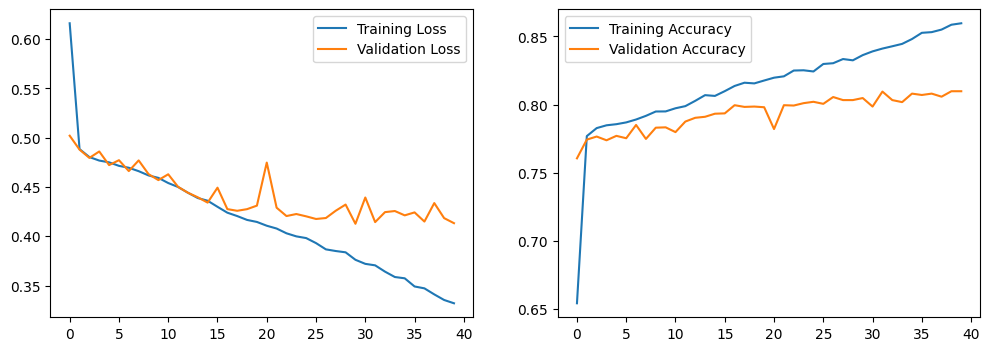

In [59]:
plot_history(hist2)

<font color = 'blue'>
<font size = 3>
Predicting on the test set, submitting the predictions to Kaggle, and getting a score from the competition.

In [60]:
res = predictOnTeset(model2)

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


In [61]:
subms = createFileAndUploadToKaggle('Model2Submission.csv', res)

100%|██████████| 2.84M/2.84M [00:00<00:00, 6.78MB/s]


In [62]:
score = getKaggleScore(subms)

The accuracy score is 0.8769


<font color = 'blue'>
<font size = 3>
In the above model, I removed the max-pooling layers and instead used conv2D layers with stride 2 in both the directions. The result on the test set are pretty much similar to the previous model with max pooling layers and stride of 1.<br><br>
In the accuracy and loss plots, we see that the validation curves still haven't fully plateued out, seemingly implying that there is still some potential for further improvements with higher number of epochs, although the remaining possible improvement should be tiny given the almost flat nature of the validation curves.


### Using Batch renormalization with max-pooling layers and strides of 1 in the convolution layers.

In [63]:
input_shape = (96, 96, 3) # appropriate with the input data
model_withBatchRenormalization = keras.Sequential([
    layers.Input(shape=input_shape),
    layers.Rescaling(1./255),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.Rescaling(1./255),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(512, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid') # For binary classification
  ])

model_withBatchRenormalization.compile(loss='binary_crossentropy',
              metrics=['accuracy'])
model_withBatchRenormalization.optimizer = Adam(learning_rate= 0.0001)

model_withBatchRenormalization.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_7 (Rescaling)              │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 94, 94, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_8 (Rescaling)              │ (None, 94, 94, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 47, 47, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 45, 45, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 20, 20, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 20, 20, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 2, 2, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 2, 2, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 1, 1, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 1,638,209 (6.25 MB)

 Trainable params: 1,636,289 (6.24 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [64]:
es1 = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
histwithBatchRenormalization = model_withBatchRenormalization.fit(X_train, y_train, validation_split=0.2, epochs=50, callbacks=[es1])

Epoch 1/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.7639 - loss: 0.5193 - val_accuracy: 0.5962 - val_loss: 0.8111
Epoch 2/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.8325 - loss: 0.3779 - val_accuracy: 0.6565 - val_loss: 0.8558
Epoch 3/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.8747 - loss: 0.3054 - val_accuracy: 0.6185 - val_loss: 1.3749
Epoch 4/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9122 - loss: 0.2246 - val_accuracy: 0.6850 - val_loss: 0.8217
Epoch 5/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9519 - loss: 0.1357 - val_accuracy: 0.8037 - val_loss: 0.4953
Epoch 6/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9759 - loss: 0.0808 - val_accuracy: 0.7157 - val_loss: 0.6581
Epoch 7/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9837 - loss: 0.0582 - val_accuracy: 0.5997 - val_loss: 1.0048
Epoch 8/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9867 - loss: 0.0441 - val_acc

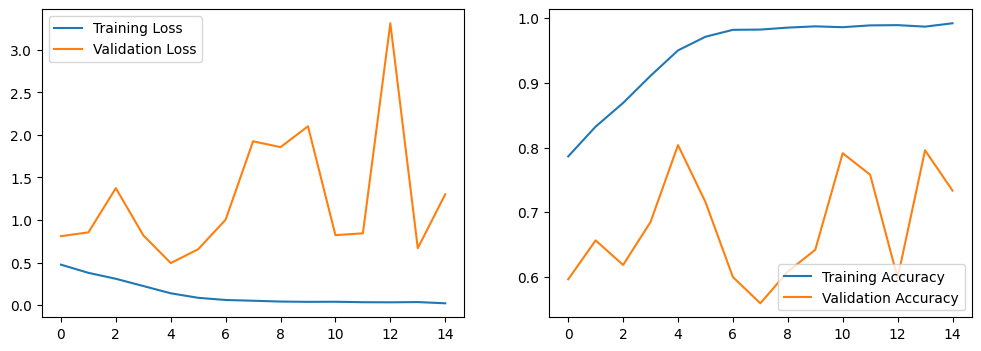

In [65]:
plot_history(histwithBatchRenormalization)

<font color = 'blue'><font size = 3>
Performing prediction on the test set, and then submitting the predictions to Kaggle, and getting a score from the competition.

In [66]:
res = predictOnTeset(model_withBatchRenormalization)
subms = createFileAndUploadToKaggle('ModelWithBatchRenormalization.csv', res)

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step


100%|██████████| 2.86M/2.86M [00:00<00:00, 6.86MB/s]


In [67]:
score = getKaggleScore(subms)

The accuracy score is 0.8921


<font color = 'blue'><font size = 3>
In the above model, we used batch renormalization while also keeping max-pooling layers and conv2d layers with strides = 1. We see from the above plots that the validation results are very noisy; however, it still gave an accuracy pretty similar to the previous models on the test dataset.

### Using dropout with max-pooling layers and conv2D layers with stride = 1.

In [68]:
input_shape = (96, 96, 3) # appropriate with the input data
model_withDropOut = keras.Sequential([
    layers.Input(shape=input_shape),
    layers.Rescaling(1./255),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.Rescaling(1./255),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Dropout(0.2),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.Dropout(0.2),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.Dropout(0.2),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid') # For binary classification
  ])

model_withDropOut.compile(loss='binary_crossentropy',
              metrics=['accuracy'])
model_withDropOut.optimizer = Adam(learning_rate= 0.0005)

model_withDropOut.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_9 (Rescaling)              │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 94, 94, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_10 (Rescaling)             │ (None, 94, 94, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 47, 47, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 20, 20, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │         524,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 912,961 (3.48 MB)

 Trainable params: 912,961 (3.48 MB)

 Non-trainable params: 0 (0.00 B)

In [69]:
es1 = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
histwithDropout = model_withDropOut.fit(X_train, y_train, validation_split=0.2, epochs=50, callbacks=[es1])

Epoch 1/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.6031 - loss: 0.6661 - val_accuracy: 0.5420 - val_loss: 0.6938
Epoch 2/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.7628 - loss: 0.5103 - val_accuracy: 0.7857 - val_loss: 0.5173
Epoch 3/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.7715 - loss: 0.4915 - val_accuracy: 0.7795 - val_loss: 0.4844
Epoch 4/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.7737 - loss: 0.4891 - val_accuracy: 0.7822 - val_loss: 0.4996
Epoch 5/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.7891 - loss: 0.4713 - val_accuracy: 0.7383 - val_loss: 0.5406
Epoch 6/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.7850 - loss: 0.4747 - val_accuracy: 0.7918 - val_loss: 0.4801
Epoch 7/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.7861 - loss: 0.4671 - val_accuracy: 0.7887 - val_loss: 0.4829
Epoch 8/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.7900 - loss: 0.4585 - val_acc

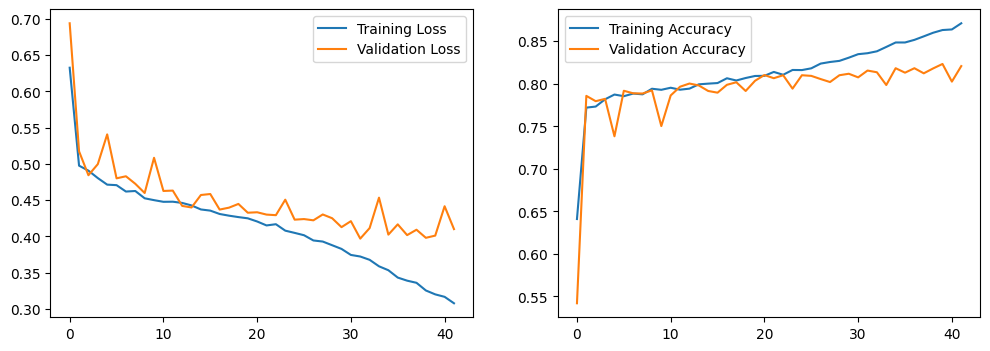

In [70]:
plot_history(histwithDropout)

<font color = 'blue'>
<font size = 3>
Predicting on the test set, submitting the predictions to Kaggle, and getting a score from the competition.

In [71]:
res = predictOnTeset(model_withDropOut)
subms = createFileAndUploadToKaggle('ModelWithDropOut.csv', res)

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


100%|██████████| 2.84M/2.84M [00:00<00:00, 6.97MB/s]


In [73]:
score = getKaggleScore(subms)

The accuracy score is 0.8927


<font color = 'blue'><font size = 3>
Above, we made a CNN model using drop-outs to avoid overfitting. The accuracy and loss curves of both the training set and the validation set lie proximate to each other and depart from each other only after 20 epochs, indicating that the model avoids overfitting better than other previously discussed moels.<br>
As for the accuracy on test set, we find it about 89.27%, a value similar to those obtained using earlier models.

## Model using the RMS prop optimizer 

In [74]:
def createModel(optimizer):
  input_shape = (96, 96, 3) # appropriate with the input data
  model = keras.Sequential([
    layers.Input(shape=input_shape),
    layers.Rescaling(1./255),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.Rescaling(1./255),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Dropout(0.2),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.Dropout(0.2),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid') # For binary classification
  ])

  model.compile(optimizer= optimizer, loss='binary_crossentropy',
                metrics=['accuracy'])

  model.summary()
  return model
modelRMS_prop = createModel(optimizer = 'RMSprop')

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_11 (Rescaling)             │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 94, 94, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_12 (Rescaling)             │ (None, 94, 94, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 47, 47, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_30 (Conv2D)                   │ (None, 20, 20, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 128)                 │       1,638,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,731,905 (6.61 MB)

 Trainable params: 1,731,905 (6.61 MB)

 Non-trainable params: 0 (0.00 B)

Using RMS prop optimizer

In [75]:
es1 = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
histRMS_prop = modelRMS_prop.fit(X_train, y_train, validation_split=0.2, epochs=50, callbacks=[es1])

Epoch 1/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.5955 - loss: 0.6771 - val_accuracy: 0.5962 - val_loss: 0.6733
Epoch 2/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.6007 - loss: 0.6594 - val_accuracy: 0.6685 - val_loss: 0.6569
Epoch 3/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.7004 - loss: 0.5928 - val_accuracy: 0.7585 - val_loss: 0.5486
Epoch 4/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.7523 - loss: 0.5281 - val_accuracy: 0.7853 - val_loss: 0.5022
Epoch 5/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.7550 - loss: 0.5113 - val_accuracy: 0.7335 - val_loss: 0.5274
Epoch 6/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.7720 - loss: 0.4880 - val_accuracy: 0.7750 - val_loss: 0.5088
Epoch 7/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.7756 - loss: 0.4894 - val_accuracy: 0.7843 - val_loss: 0.5032
Epoch 8/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.7780 - loss: 0.4889 - val_accu

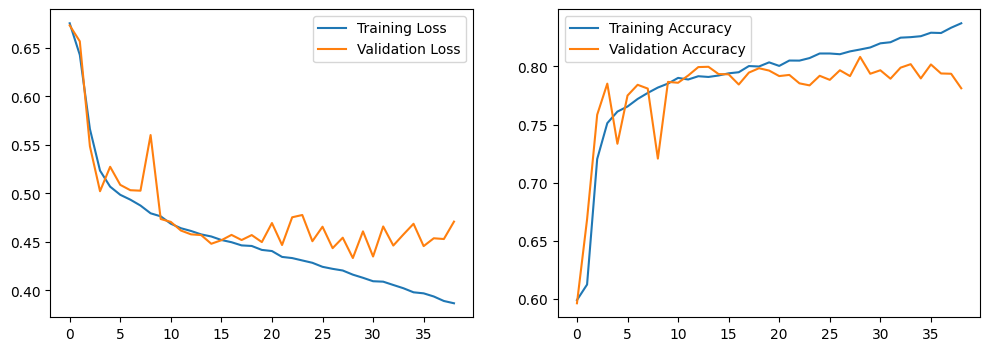

In [76]:
plot_history(histRMS_prop)

<font color = 'blue'>
<font size = 3>
Predicting on the test set, submitting the predictions to Kaggle, and getting a score from the competition.

In [77]:
res = predictOnTeset(modelRMS_prop)
subms = createFileAndUploadToKaggle('ModelRMSprop.csv', res)

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


100%|██████████| 2.84M/2.84M [00:00<00:00, 6.78MB/s]


In [78]:
score = getKaggleScore(subms)

The accuracy score is 0.8882


<font color = 'blue'>
<font size = 3>
In the above model, I again used a basic model with three convolution layers followed by max-pooling layers, but with an RMS prop optimizer. This again performs quite similar to the Adams optimizer, giving a test set accuracy of 0.8882.

## Conlusion

<p style="font-size: 16px; color: blue;">
We created the following models and their results on the test dataset are as follows:<br></p>

<table>
  <p style="font-size: 16px; color: blue;">
  <tr>
    <th>Model type</th>
    <th>Test set accuracy</th>
  </tr>
  <tr>
    <td>Basic model: 3 Convolution layers followed by max-pooling layers, Adam optimizer</td>
    <td>0.8863</td>
  </tr>
  <tr>
    <td>Basic model: 3 Convolution layers followed by max-pooling layers, RMS prop optimizer</td>
    <td>0.8882</td>
  </tr>
  <tr>
    <td>5 Convolution layers with stride  and no max-pooling layer, Adam optimizer</td>
    <td>0.8769</td>
  </tr>
  <tr>
    <td>5 Convolution layers followed by batch normalization and max-pooling layers, Adam optimizer</td>
    <td>0.8921</td>
  </tr>
  <tr>
    <td>5 Convolution layers with stride (2,2) followed by max-pooling layers and dropouts, Adam optimizer</td>
    <td>0.8927</td>
  </tr>
  </p>
</table>

<p style="font-size: 16px; color: blue;">
It seems like we can make the following conclusions:<br>

<ul>
  <li> <p style="font-size: 16px; color: blue;"> We used only 20K points out of more than 200K points available for training. There is a potential to improve the fit by utilizing more data. However, it would significantly increase the overhead.</p></li>
  <li> <p style="font-size: 16px; color: blue;"> Increasing the number of convolution layers from 3 to 5 doesn't seem to make much of a difference to accuracy.</p></li>
  <li> <p style="font-size: 16px; color: blue;"> Using stride of 2 instead 1 and max-pooling with (2,2) dimension to reduce the size of the net do not affect the model substantially. Both model provided similar accuarcies on the test set.</p></li>
  <li> <p style="font-size: 16px; color: blue;"> Use of Batch normalization probably made the results noisy; however, it still gave results on the test set similar to other models</p></li>
  <li> <p style="font-size: 16px; color: blue;"> Changing the optimizer from Adam to RMS_prop also didn't improve accuracy of the model. However, we still have more room to play with learning rates and other hyperparameters of the optimizers.</p></li>
</ul>
</p>